## General imports and references
References:
- https://scikit-learn.org/dev/modules/generated/sklearn.ensemble.RandomForestRegressor.html
- https://medium.com/@merilainen.vili/how-to-encode-categorical-values-for-multiple-columns-scikit-learn-66fd3671384b
- https://www.geeksforgeeks.org/random-forest-regression-in-python/
- https://xgboost.readthedocs.io/en/latest/index.html

In [ ]:
# Install libraries
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import scipy

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Sklearn imports
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error
import xgboost as xgb
import matplotlib.pyplot as plt

# Google drive mount
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/COMP685')

# Avoids scroll-in-the-scroll in the entire Notebook
from IPython.display import Javascript
def resize_colab_cell():
  display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'))
get_ipython().events.register('pre_run_cell', resize_colab_cell)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
df = pd.read_csv('data/testD-1.csv')
df.head(5)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Waybill Date,Origin,Origin-St,Destination,Destination-St,Commodity,Railcars-Containers,Rail-Miles,Net-Weight-Tons,Metric-Tonnes,Rail-km,Rail-GHG-Emissions-Tonnes,Truck-GHG-Emissions-Tonnes
0,2024-09-06,ROBERTS BANK,BC,EDMONTON INTER TERM,AB,Rhubarb,1,766.3,24,21.77,1233.21,0.34,2.07
1,2024-08-06,ROBERTS BANK,BC,BRAMPTON INTER TERM,ON,Barley,1,2757.8,23,20.87,4438.13,1.18,7.15
2,2024-08-06,ROBERTS BANK,BC,BRAMPTON INTER TERM,ON,Llamas,1,2757.8,9,8.16,4438.13,0.46,2.80
3,2024-08-06,ROBERTS BANK,BC,BRAMPTON INTER TERM,ON,Spinach,1,2757.8,23,20.87,4438.13,1.18,7.15
4,2024-08-06,ROBERTS BANK,BC,BRAMPTON INTER TERM,ON,Parsnip,1,2757.8,23,20.87,4438.13,1.18,7.15


In [ ]:
len(df['Commodity'].unique())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

244

In [ ]:
df.columns

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Index(['Waybill Date', 'Origin', 'Origin-St', 'Destination', 'Destination-St',
       'Commodity', 'Railcars-Containers', 'Rail-Miles', 'Net-Weight-Tons',
       'Metric-Tonnes', 'Rail-km', 'Rail-GHG-Emissions-Tonnes',
       'Truck-GHG-Emissions-Tonnes'],
      dtype='object')

In [ ]:
df.info()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7380 entries, 0 to 7379
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Waybill Date                7380 non-null   object 
 1   Origin                      7380 non-null   object 
 2   Origin-St                   7380 non-null   object 
 3   Destination                 7380 non-null   object 
 4   Destination-St              7380 non-null   object 
 5   Commodity                   7380 non-null   object 
 6   Railcars-Containers         7380 non-null   int64  
 7   Rail-Miles                  7380 non-null   float64
 8   Net-Weight-Tons             7380 non-null   int64  
 9   Metric-Tonnes               7380 non-null   float64
 10  Rail-km                     7380 non-null   float64
 11  Rail-GHG-Emissions-Tonnes   7380 non-null   float64
 12  Truck-GHG-Emissions-Tonnes  7380 non-null   float64
dtypes: float64(5), int64(2), object(6

In [ ]:
file_path = "/content/drive/MyDrive/COMP685/data/testD-1.csv"

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Data preparation

In [ ]:
class Data:
    def __init__(self, name="Dataset"):
        self.name = name
        self.trainDataset = None
        self.testDataset = None
        self.x_train = None
        self.y_train = None
        self.x_test = None
        self.y_test = None

        # Using OrdinalEncoder with encoded_values parameter
        self.encoder = OrdinalEncoder(
            handle_unknown='use_encoded_value',
            unknown_value=-1,  # Added this parameter
            encoded_missing_value=-999  # Different value for missing data
        )

        # Store column names for categorical variables
        self.categorical_cols = [
            'Waybill Date', 'Origin', 'Origin-St',
            'Destination', 'Destination-St', 'Commodity'
        ]

    def analyze_categorical_variables(self, data):
        categorical_analysis = {}

        for col in self.categorical_cols:
            # Get value counts and unique counts
            value_counts = data[col].value_counts()
            unique_count = len(value_counts)

            # Calculate frequencies and percentages
            frequencies = value_counts.values
            percentages = (value_counts / len(data) * 100).round(2)

            # Combine into a DataFrame
            category_df = pd.DataFrame({
                'Frequency': frequencies,
                'Percentage': percentages
            }, index=value_counts.index)

            # Calculate additional statistics
            stats_dict = {
                'unique_count': unique_count,
                'most_common': value_counts.iloc[0],
                'most_common_freq': frequencies[0],
                'most_common_pct': percentages.iloc[0],
                'least_common': value_counts.iloc[-1],
                'least_common_freq': frequencies[-1],
                'least_common_pct': percentages.iloc[-1],
            }

            # Combine everything into the results dictionary
            categorical_analysis[col] = {
                'summary_stats': stats_dict,
                'detailed_breakdown': category_df
            }

        return categorical_analysis

    def load_train_data(self, filename, target_col, predict_col, test_size=0.3):
        # Load data
        df = pd.read_csv(filename, encoding='utf8')

        # Split into features and target
        X = df.drop(columns=target_col)
        y = df[predict_col]

        # Split the data first
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42
        )
        self.x_train_num_vars = X_train.describe()
        self.x_test_num_vars = X_test.describe()
        self.x_train_cat_vars = self.analyze_categorical_variables(X_train)
        self.x_test_cat_vars = self.analyze_categorical_variables(X_test)
        self.feature_names = list(X.columns)

        # Extract categorical columns
        X_train_cat = X_train[self.categorical_cols]
        X_test_cat = X_test[self.categorical_cols]

        # Fit and transform on training data
        X_train_cat_encoded = self.encoder.fit_transform(X_train_cat)
        # Transform test data using the same encoder
        X_test_cat_encoded = self.encoder.transform(X_test_cat)

        # Replace categorical columns with encoded values
        X_train_encoded = X_train.copy()
        X_test_encoded = X_test.copy()
        X_train_encoded[self.categorical_cols] = X_train_cat_encoded
        X_test_encoded[self.categorical_cols] = X_test_cat_encoded

        # Convert to numpy arrays and store
        self.x_train = X_train_encoded.to_numpy()
        self.y_train = y_train.to_numpy()
        self.x_test = X_test_encoded.to_numpy()
        self.y_test = y_test.to_numpy()

        # Store full datasets
        self.trainDataset = np.column_stack((self.x_train, self.y_train))
        self.testDataset = np.column_stack((self.x_test, self.y_test))

        return self

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Load train data

co2_data = Data("CO2 Dataset")
target_col = ["Rail-GHG-Emissions-Tonnes", "Truck-GHG-Emissions-Tonnes"]
predict_col = "Truck-GHG-Emissions-Tonnes"

co2_data.load_train_data(filename=file_path, target_col=target_col, predict_col=predict_col, test_size=0.3)
print("X_train=", co2_data.x_train.shape)
print("Y_train=", co2_data.y_train.shape)
print("X_test=", co2_data.x_test.shape)
print("Y_test=", co2_data.y_test.shape)
print("Feature names: ", co2_data.feature_names)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

X_train= (5166, 11)
Y_train= (5166,)
X_test= (2214, 11)
Y_test= (2214,)
Feature names:  ['Waybill Date', 'Origin', 'Origin-St', 'Destination', 'Destination-St', 'Commodity', 'Railcars-Containers', 'Rail-Miles', 'Net-Weight-Tons', 'Metric-Tonnes', 'Rail-km']


## Random Forest Regressor, XGBoost Regressor

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import shap

class RegressorModel:
    def __init__(self, model_type='rf', model_params=None):
        self.model_type = model_type.lower()
        self.model_params = model_params if model_params is not None else {}

        if self.model_type == 'rf':
            default_params = {
                'n_estimators': 100,
                'max_depth': None,
                'random_state': 42
            }
            default_params.update(self.model_params)
            self.model = RandomForestRegressor(**default_params)

        elif self.model_type == 'xgb':
            default_params = {
                'n_estimators': 100,
                'max_depth': 6,
                'learning_rate': 0.1,
                'random_state': 42
            }
            default_params.update(self.model_params)
            self.model = xgb.XGBRegressor(**default_params)

        else:
            raise ValueError("model_type must be either 'rf' or 'xgb'")

        self.feature_importance = None
        self.metrics = None
        self.shap_values = None
        self.explainer = None

    def fit(self, X_train, y_train):
        self.model.fit(X_train, y_train)

        if self.model_type == 'rf':
            importance = self.model.feature_importances_
        elif self.model_type == 'xgb':
            importance = self.model.feature_importances_

        self.feature_importance = pd.Series(
            importance,
            index=range(X_train.shape[1])
        ).sort_values(ascending=False)

        return self

    def predict(self, X):
        return self.model.predict(X)

    def calculate_metrics(self, y_true, y_pred):
        mse = mean_squared_error(y_true, y_pred)
        rmse = root_mean_squared_error(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        mape = mean_absolute_percentage_error(y_true, y_pred)

        return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'R2': r2}

    def evaluate(self, X_train, X_test, y_train, y_test):
        y_train_pred = self.predict(X_train)
        y_test_pred = self.predict(X_test)

        train_metrics = self.calculate_metrics(y_train, y_train_pred)
        test_metrics = self.calculate_metrics(y_test, y_test_pred)

        self.metrics = {'train': train_metrics, 'test': test_metrics}

        return self.metrics

    def calculate_shap_values(self, X):
        self.explainer = shap.TreeExplainer(self.model, X)
        self.shap_values = self.explainer(X)
        return self.shap_values

    def plot_shap_summary(self, X, feature_names=None, plot_type="bar"):
        if self.shap_values is None:
            self.calculate_shap_values(X)

        plt.figure(figsize=(10, 6))
        if plot_type == "bar":
            shap.plots.bar(self.shap_values)
        elif plot_type == "beeswarm":
            shap.plots.beeswarm(self.shap_values)

        plt.tight_layout()
        plt.show()

    def get_feature_importance(self, feature_names=None):
        if feature_names is not None:
            self.feature_importance.index = feature_names
        return self.feature_importance.to_frame('importance')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
X_train = co2_data.x_train
y_train = co2_data.y_train
X_test = co2_data.x_test
y_test = co2_data.y_test

X_train = pd.DataFrame(X_train, columns=co2_data.feature_names)
X_test = pd.DataFrame(X_test, columns=co2_data.feature_names)

rf = RegressorModel('rf')
rf.fit(X_train, y_train)

rf.evaluate(X_train, X_test, y_train, y_test)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{'train': {'MSE': 0.00035896361595043986,
  'RMSE': 0.018946335158822665,
  'MAE': 0.002610181958966118,
  'MAPE': 0.0009930911503817305,
  'R2': 0.9999340862975751},
 'test': {'MSE': 0.004036297615176137,
  'RMSE': 0.06353186299154258,
  'MAE': 0.008716079494131728,
  'MAPE': 0.002746160677451844,
  'R2': 0.9992576008746447}}

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 99%|===================| 5134/5166 [01:58<00:00]       

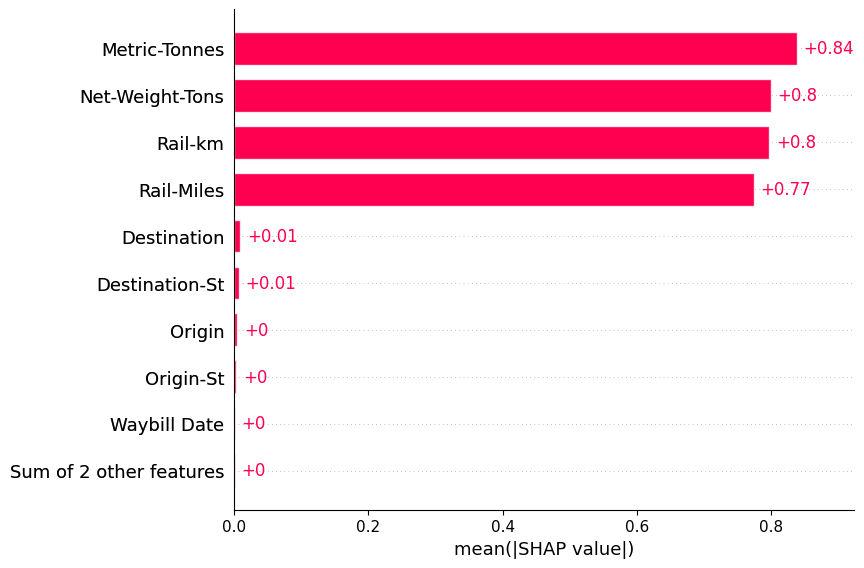

<Figure size 640x480 with 0 Axes>

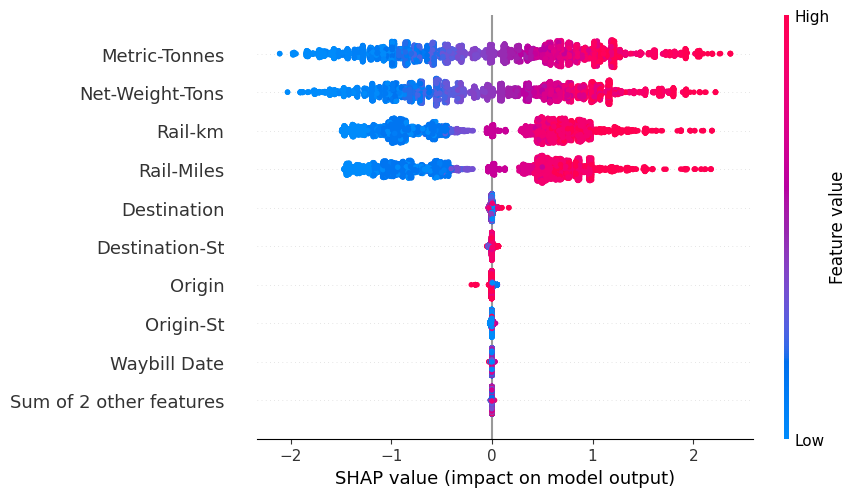

<Figure size 640x480 with 0 Axes>

In [ ]:
rf.calculate_shap_values(X_train)

rf.plot_shap_summary(X_train, feature_names=co2_data.feature_names, plot_type="bar")
rf.plot_shap_summary(X_train, feature_names=co2_data.feature_names, plot_type="beeswarm")

## XGBoost Regressor

In [ ]:
xgb = RegressorModel('xgb')
xgb.fit(X_train, y_train)

xgb.evaluate(X_train, X_test, y_train, y_test)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{'train': {'MSE': 0.0001820424221119163,
  'RMSE': 0.013492309739696768,
  'MAE': 0.0074877777678348835,
  'MAPE': 0.003631283981682599,
  'R2': 0.9999665729630898},
 'test': {'MSE': 0.002914990879889227,
  'RMSE': 0.05399065548675277,
  'MAE': 0.012675559413034616,
  'MAPE': 0.004951979484937416,
  'R2': 0.9994638436294906}}

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 97%|=================== | 5010/5166 [00:24<00:00]       

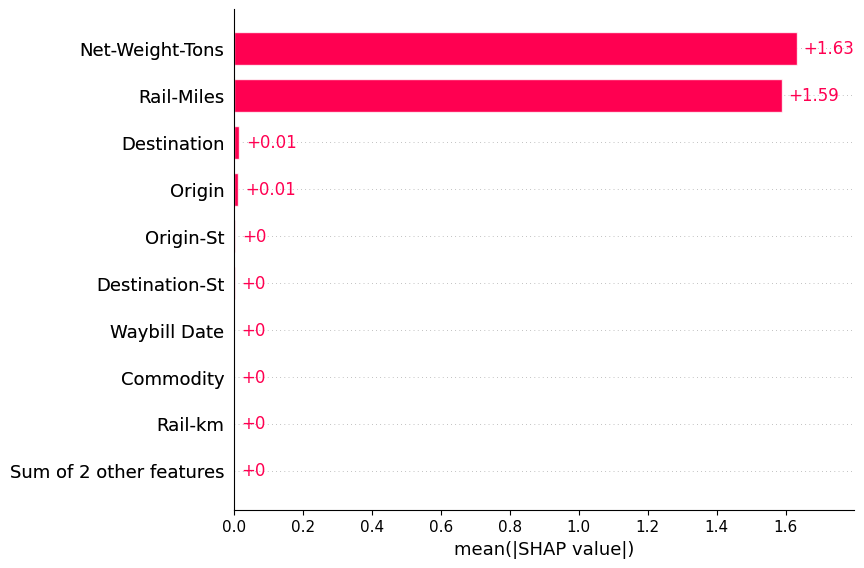

<Figure size 640x480 with 0 Axes>

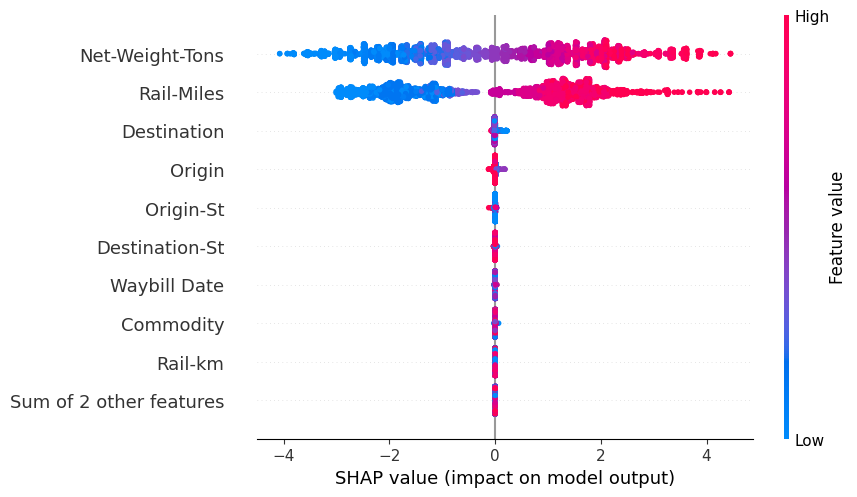

<Figure size 640x480 with 0 Axes>

In [ ]:
xgb.calculate_shap_values(X_train)

xgb.plot_shap_summary(X_train, feature_names=co2_data.feature_names, plot_type="bar")
xgb.plot_shap_summary(X_train, feature_names=co2_data.feature_names, plot_type="beeswarm")

## MLP

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class MLPRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dims=[64, 32], dropout=0.2):
        super().__init__()

        # Build layers dynamically
        layers = []
        prev_dim = input_dim

        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
                nn.BatchNorm1d(hidden_dim),
                nn.Dropout(dropout)
            ])
            prev_dim = hidden_dim

        # Output layer
        layers.append(nn.Linear(prev_dim, 1))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x).squeeze()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
class MLPTrainer:
    def __init__(self, input_dim, hidden_dims=[64, 32], dropout=0.2,
                 learning_rate=0.001, batch_size=32, epochs=100, device='cuda'):
        self.device = torch.device(device if torch.cuda.is_available() and device=='cuda' else 'cpu')
        self.model = MLPRegressor(input_dim, hidden_dims, dropout).to(self.device)
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.history = {'train_loss': [], 'val_loss': []}
        self.metrics = None

    def fit(self, X_train, y_train, X_val=None, y_val=None):
        train_dataset = CustomDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)

        if X_val is not None and y_val is not None:
            val_dataset = CustomDataset(X_val, y_val)
            val_loader = DataLoader(val_dataset, batch_size=self.batch_size)

        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        criterion = nn.MSELoss()

        # Training loop
        for epoch in range(self.epochs):
            self.model.train()
            train_losses = []

            for batch_X, batch_y in train_loader:
                batch_X = batch_X.to(self.device)
                batch_y = batch_y.to(self.device)

                optimizer.zero_grad()
                outputs = self.model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()

                train_losses.append(loss.item())

            avg_train_loss = np.mean(train_losses)
            self.history['train_loss'].append(avg_train_loss)

            # Validation step
            if X_val is not None and y_val is not None:
                self.model.eval()
                val_losses = []

                with torch.no_grad():
                    for batch_X, batch_y in val_loader:
                        batch_X = batch_X.to(self.device)
                        batch_y = batch_y.to(self.device)

                        outputs = self.model(batch_X)
                        loss = criterion(outputs, batch_y)
                        val_losses.append(loss.item())

                avg_val_loss = np.mean(val_losses)
                self.history['val_loss'].append(avg_val_loss)

                if (epoch + 1) % 10 == 0:
                    print(f'Epoch [{epoch+1}/{self.epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
            else:
                if (epoch + 1) % 10 == 0:
                    print(f'Epoch [{epoch+1}/{self.epochs}], Train Loss: {avg_train_loss:.4f}')

    def predict(self, X):
        self.model.eval()
        X_tensor = torch.FloatTensor(X).to(self.device)

        with torch.no_grad():
            predictions = self.model(X_tensor)

        return predictions.cpu().numpy()

    def calculate_metrics(self, y_true, y_pred):
        mse = mean_squared_error(y_true, y_pred)
        rmse = root_mean_squared_error(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        mape = mean_absolute_percentage_error(y_true, y_pred)

        return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape,'R2': r2}

    def evaluate(self, X_train, X_test, y_train, y_test):
        y_train_pred = self.predict(X_train)
        y_test_pred = self.predict(X_test)

        train_metrics = self.calculate_metrics(y_train, y_train_pred)
        test_metrics = self.calculate_metrics(y_test, y_test_pred)

        self.metrics = {
            'train': train_metrics,
            'test': test_metrics
        }

        return self.metrics

    def plot_training_history(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.history['train_loss'], label='Training Loss')
        if 'val_loss' in self.history and self.history['val_loss']:
            plt.plot(self.history['val_loss'], label='Validation Loss')
        plt.title('Training History')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch [10/10], Train Loss: 0.5696, Val Loss: 0.0342
Train Metrics: {'MSE': 0.030720930087121068, 'RMSE': 0.17527387166124067, 'MAE': 0.12507302583902324, 'MAPE': 0.07365128314951544, 'R2': 0.9943589540722159}
Test Metrics: {'MSE': 0.03421379610912353, 'RMSE': 0.18496971673526325, 'MAE': 0.12865764118630063, 'MAPE': 0.07664990171925762, 'R2': 0.9937070318573645}


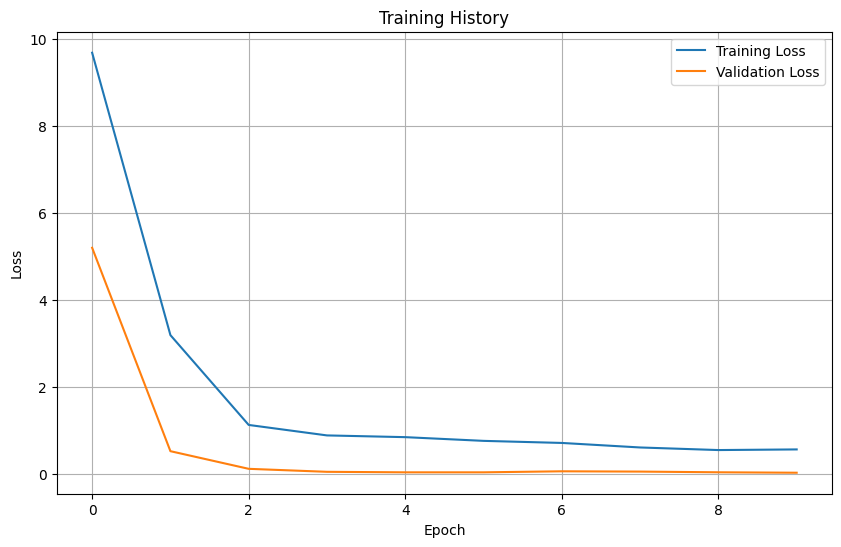

In [ ]:
X_train = co2_data.x_train
y_train = co2_data.y_train
X_test = co2_data.x_test
y_test = co2_data.y_test

import sklearn.preprocessing as pp
scaler = pp.StandardScaler().fit(X_train)
X_train, X_test = scaler.transform(X_train), scaler.transform(X_test)

trainer = MLPTrainer(
    input_dim=X_train.shape[1],
    hidden_dims=[64, 32],
    dropout=0.2,
    learning_rate=0.001,
    batch_size=32,
    epochs=10
)

# Train model
trainer.fit(X_train, y_train, X_test, y_test)

# Evaluate model
metrics = trainer.evaluate(X_train, X_test, y_train, y_test)
print("Train Metrics:", metrics['train'])
print("Test Metrics:", metrics['test'])

# Plot training history
trainer.plot_training_history()

## LSTM

In [ ]:
class CustomDataset(Dataset):
    """Custom Dataset for loading the data"""
    def __init__(self, X, y, sequence_length=1):
        # Reshape X to [batch_size, sequence_length, feature_dim]
         # Add sequence dimension, sequence_length = 1
        self.X = torch.FloatTensor(X).unsqueeze(1)
        self.y = torch.FloatTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class LSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.2):
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        self.reg_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 1)
        )

    def forward(self, x):
        # LSTM output: [batch_size, seq_len, hidden_dim]
        lstm_out, _ = self.lstm(x)
        # Take the last sequence output
        last_output = lstm_out[:, -1, :]
        # Regression head
        out = self.reg_head(last_output)
        return out.squeeze()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
class LSTMTrainer:
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.2,
                 learning_rate=0.001, batch_size=32, epochs=100, device='cuda'):
        self.device = torch.device(device if torch.cuda.is_available() and device=='cuda' else 'cpu')
        self.model = LSTMRegressor(input_dim, hidden_dim, num_layers, dropout).to(self.device)
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.history = {'train_loss': [], 'val_loss': []}
        self.metrics = None

    def fit(self, X_train, y_train, X_val=None, y_val=None):
        """Train the model"""
        # Create data loaders
        train_dataset = CustomDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)

        if X_val is not None and y_val is not None:
            val_dataset = CustomDataset(X_val, y_val)
            val_loader = DataLoader(val_dataset, batch_size=self.batch_size)

        # Initialize optimizer and loss function
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        criterion = nn.MSELoss()

        # Training loop
        for epoch in range(self.epochs):
            self.model.train()
            train_losses = []

            # Training step
            for batch_X, batch_y in train_loader:
                batch_X = batch_X.to(self.device)
                batch_y = batch_y.to(self.device)

                optimizer.zero_grad()
                outputs = self.model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()

                train_losses.append(loss.item())

            avg_train_loss = np.mean(train_losses)
            self.history['train_loss'].append(avg_train_loss)

            # Validation step
            if X_val is not None and y_val is not None:
                self.model.eval()
                val_losses = []

                with torch.no_grad():
                    for batch_X, batch_y in val_loader:
                        batch_X = batch_X.to(self.device)
                        batch_y = batch_y.to(self.device)

                        outputs = self.model(batch_X)
                        loss = criterion(outputs, batch_y)
                        val_losses.append(loss.item())

                avg_val_loss = np.mean(val_losses)
                self.history['val_loss'].append(avg_val_loss)

                if (epoch + 1) % 10 == 0:
                    print(f'Epoch [{epoch+1}/{self.epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
            else:
                if (epoch + 1) % 10 == 0:
                    print(f'Epoch [{epoch+1}/{self.epochs}], Train Loss: {avg_train_loss:.4f}')

    def predict(self, X):
        """Make predictions"""
        self.model.eval()
        # Reshape X to include sequence dimension
        X_tensor = torch.FloatTensor(X).unsqueeze(1).to(self.device)

        with torch.no_grad():
            predictions = self.model(X_tensor)

        return predictions.cpu().numpy()

    def calculate_metrics(self, y_true, y_pred):
        """Calculate regression metrics"""
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        mape = mean_absolute_percentage_error(y_true, y_pred)

        return {
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'MAPE': mape,
            'R2': r2
        }

    def evaluate(self, X_train, X_test, y_train, y_test):
        """Evaluate model performance"""
        y_train_pred = self.predict(X_train)
        y_test_pred = self.predict(X_test)

        train_metrics = self.calculate_metrics(y_train, y_train_pred)
        test_metrics = self.calculate_metrics(y_test, y_test_pred)

        self.metrics = {
            'train': train_metrics,
            'test': test_metrics
        }

        return self.metrics

    def plot_training_history(self):
        """Plot training history"""
        plt.figure(figsize=(10, 6))
        plt.plot(self.history['train_loss'], label='Training Loss')
        if 'val_loss' in self.history and self.history['val_loss']:
            plt.plot(self.history['val_loss'], label='Validation Loss')
        plt.title('Training History')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
X_train = co2_data.x_train
y_train = co2_data.y_train
X_test = co2_data.x_test
y_test = co2_data.y_test

import sklearn.preprocessing as pp
scaler = pp.StandardScaler().fit(X_train)
X_train, X_test = scaler.transform(X_train), scaler.transform(X_test)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch [10/10], Train Loss: 0.3996, Val Loss: 0.0294
Test Metrics: {'MSE': 0.029378629484857158, 'RMSE': 0.1714019529785386, 'MAE': 0.11774198403472605, 'MAPE': 0.05941722389892131, 'R2': 0.9945963675345222}


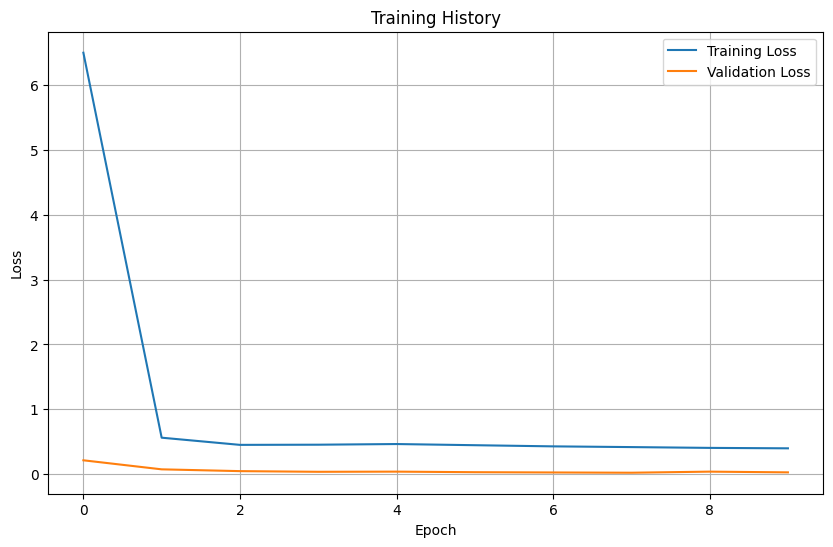

In [ ]:
# Initialize trainer
trainer = LSTMTrainer(
    input_dim=X_train.shape[1],
    hidden_dim=64,
    num_layers=2,
    dropout=0.2,
    learning_rate=0.001,
    batch_size=32,
    epochs=10
)

# Train model
trainer.fit(X_train, y_train, X_test, y_test)

# Evaluate model
metrics = trainer.evaluate(X_train, X_test, y_train, y_test)
print("Test Metrics:", metrics['test'])

# Plot training history
trainer.plot_training_history()
